# Fine-tune Pix2Struct using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Model overview

In this tutorial, we will load an architecture called Pix2Struct recently released by Google and made them available on 🤗 Hub! This architecture differs from other models from its pretraining procedure and the way the model extract patches from the image by using the aspect-ratio preserving patch extraction method.

![Fig5 paper](https://user-images.githubusercontent.com/49240599/224268204-f97d76b4-54e4-470a-aa44-9b6c086c8369.png)

The release came with no more than 20 checkpoints! 

![Screenshot 2023-03-10 at 09 42 19](https://user-images.githubusercontent.com/49240599/224267136-389b8300-6497-4321-a6cc-d85b4f8e55d7.png)

As each checkpoint has been finetuned on specific domain, let's finetune our own Pix2Struct to our target domain: Football players! For that we will use the [`google/pix2struct-base`](https://huggingface.co/ybelkada/pix2struct-base) which corresponds to a general usecase model that you can load to fine-tune your model.

## Set-up environment

Run the cells below to setup the environment

In [ ]:
!pip install -q git+https://github.com/younesbelkada/transformers.git@add-pix2struct-clean

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.3 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.9 MB/s eta 0:00:00


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that. The dataset only consists of 6 images that we have manually labeled for the sake of the tutorial.

In [ ]:
from datasets import load_dataset 

dataset = load_dataset("ybelkada/football-dataset", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/ybelkada___parquet/ybelkada--football-dataset-1ad065f8e9005a29/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["text"]

"Benzema after Real Mardid's win against PSG"

And the corresponding image

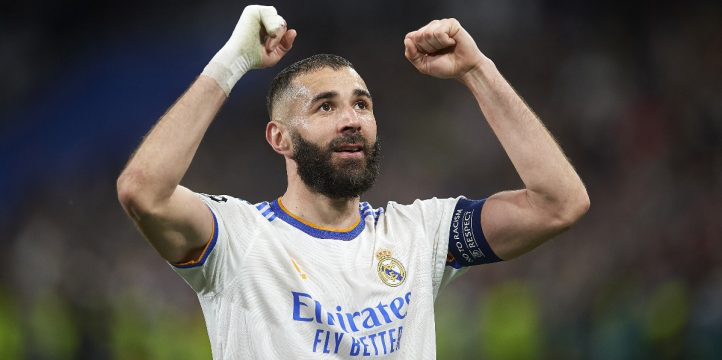

In [ ]:
dataset[0]["image"]

## Create PyTorch Dataset

### Understanding `max_patches` argument

The paper introduces a new paradigm for processing the input image. It takes the image and create `n_patches` aspect-ratio preserving patches, and concatenates the remaining sequence with padding tokens to finally get `max_patches` patches. It appears that this argument is quite crucial for training and evaluation, as the model becomes very sensitive to this parameter.

For the sake of our example, we will fine-tune a model with `max_patches=1024`.

Note that most of the `-base` models have been fine-tuned with `max_patches=2048`, and `4096` for `-large` models.

In [ ]:
from torch.utils.data import Dataset, DataLoader

MAX_PATCHES = 1024

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
        
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

## Load model and processor

In [ ]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base")
model = Pix2StructForConditionalGeneration.from_pretrained("ybelkada/pix2struct-base")

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
def collator(batch):
  new_batch = {"flattened_patches":[], "attention_mask":[]}
  texts = [item["text"] for item in batch]
  
  text_inputs = processor(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=20)
  
  new_batch["labels"] = text_inputs.input_ids
  
  for item in batch:
    new_batch["flattened_patches"].append(item["flattened_patches"])
    new_batch["attention_mask"].append(item["attention_mask"])
  
  new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
  new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

  return new_batch

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

## Train the model

Let's train the model! Run the simply the cell below for training the model. We have observed that finding the best hyper-parameters was quite challenging and required a lot of trials and errors, as the model can easily enter in "collapse-model" (always predicting the same output, no matter the input) if the HP are not chosen correctly. In this example, we found out that using `AdamW` optimizer with `lr=1e-5` seemed to be the best approach.

Let's also print the generation output of the model each 20 epochs!

Bear in mind that the model took some time to converge, for instance to get decent results we had to let the script run for ~1hour. 

In [ ]:
import torch

EPOCHS = 5000

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(EPOCHS):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    labels = batch.pop("labels").to(device)
    flattened_patches = batch.pop("flattened_patches").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    outputs = model(flattened_patches=flattened_patches,
                    attention_mask=attention_mask,
                    labels=labels)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    if (epoch + 1) % 20 == 0:
        model.eval()

        predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)        
        print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))

        model.train()

## Inference

Let's check the results on our train dataset

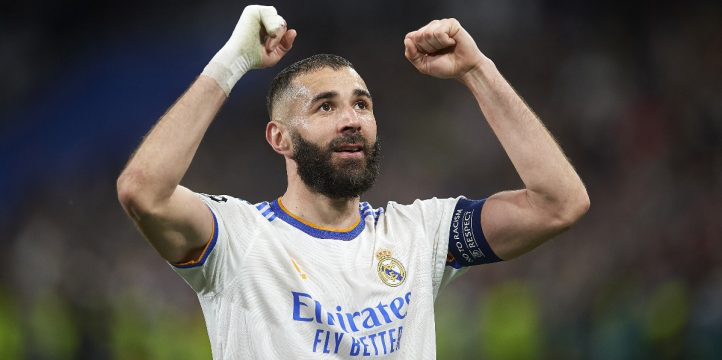

In [ ]:
# load image
example = dataset[0]
image = example["image"]
image

In [ ]:
# prepare image for the model
model.eval()

inputs = processor(images=image, return_tensors="pt", max_patches=512).to(device)

flattened_patches = inputs.flattened_patches
attention_mask = inputs.attention_mask

generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
import torch
from transformers import Pix2StructForConditionalGeneration, AutoProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Pix2StructForConditionalGeneration.from_pretrained("ybelkada/pix2struct-base-football").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/pix2struct-base-football")

Let's check the results on our train dataset!

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

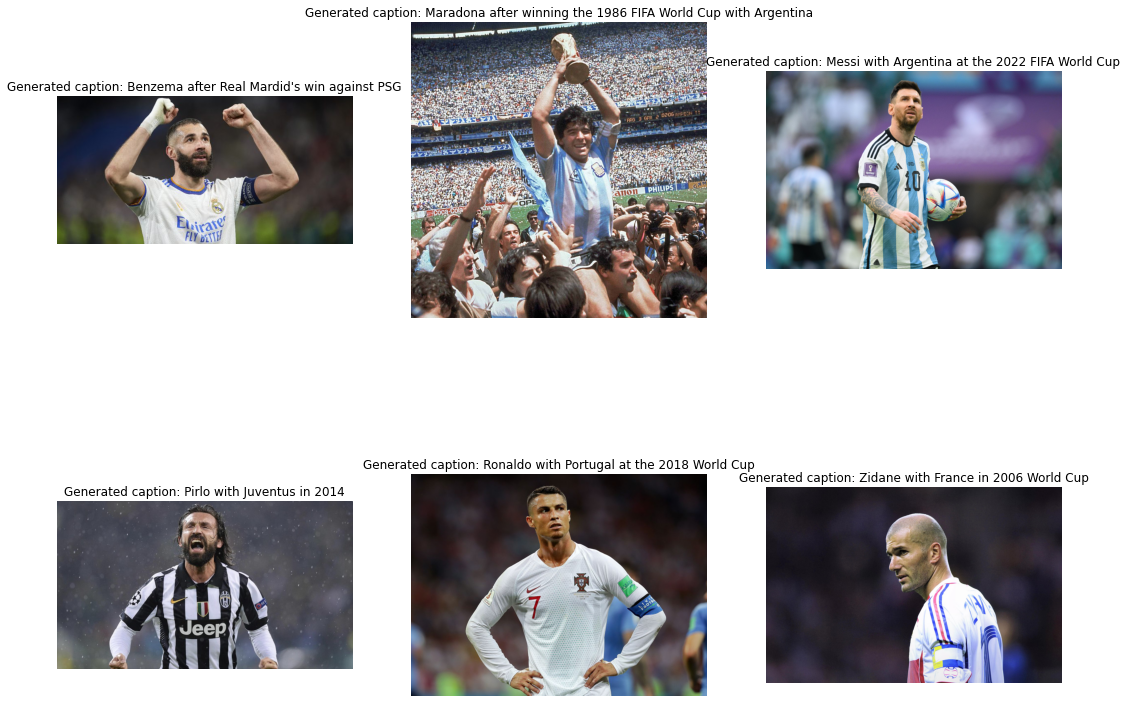

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt", max_patches=1024).to(device)
  flattened_patches = inputs.flattened_patches
  attention_mask = inputs.attention_mask

  generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")